In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torch
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import optim
import torch.nn as nn

In [4]:
# !pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.0 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/250.0 kB 660.6 kB/s eta 0:00:01
   ------------ -------------------------- 81.9/250.0 kB 762.6 kB/s eta 0:00:01
   ------------------------------- -------- 194.6/250.0 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 250.0/250.0 kB 1.3 MB/s eta 0:00:00


In [30]:
# !pip install transformers

     ---------------------------------------- 0.0/137.6 kB ? eta -:--:--
     -------- ------------------------------ 30.7/137.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 137.6/137.6 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   - -------------------------------------- 0.4/9.0 MB 8.2 MB/s eta 0:00:02
   ---- ----------------------------------- 1.0/9.0 MB 13.3 MB/s eta 0:00:01
   ------ --------------------------------- 1.5/9.0 MB 13.5 MB/s eta 0:00:01
   ------ --------------------------------- 1.5/9.0 MB 13.5 MB/s eta 0:00:01
   ------ --------------------------------- 1.5/9.0 MB 13.5 MB/s eta 0:00:01
   ------ --------------------------------- 1.5/9.0 MB 13.5 MB/s eta 0:00:01
   ------ --------------------------------- 1.5/9.0 MB 13.5 MB/s eta 0:00:01
   ------ --------------------------------- 1.5/9.0 MB 13.5 MB/s eta 0:00:01
   ----------- ---------------------------- 2.5/9.0 MB 6.2 MB/s eta 0:00:02
   ----

In [42]:
en = pd.read_excel('data/English.xlsx', usecols=['seg'])
de = pd.read_excel('data/German.xlsx', usecols=['seg'])


spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

# 토큰화 함수
# 독일어
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

# 영어
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# 토큰화 함수 적용
de_tok = [tokenize_de(text) for text in de['seg']]
en_tok = [tokenize_en(text) for text in en['seg']]


UNK, PAD, BOS, EOS = (0, 1, 2, 3)
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# 어휘사전 구축
vocab_de = build_vocab_from_iterator(de_tok, min_freq=1, special_first=True, specials=special_symbols)
vocab_en = build_vocab_from_iterator(en_tok, min_freq=1, special_first=True, specials=special_symbols)

# 특수 토큰의 기본 인덱스 설정
for vocab in [vocab_de, vocab_en]:
    vocab.set_default_index(UNK)

In [41]:

for i in de_tok:
    print(i)
    break

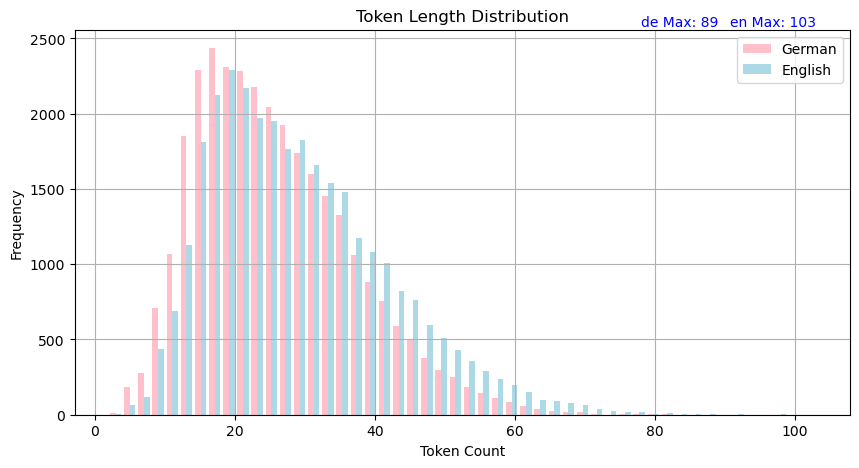

In [57]:
import matplotlib.pyplot as plt

# 각 언어의 토큰 갯수 저장
de_token_lengths = [len(tokens) for tokens in de_tok]
en_token_lengths = [len(tokens) for tokens in en_tok]

# 히스토그램 생성
plt.figure(figsize=(10, 5))
plt.hist([de_token_lengths, en_token_lengths], bins=50, label=['German', 'English'], color=['pink', 'lightblue'])
plt.title('Token Length Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend()

# 최대값 텍스트 추가
max_de = max(de_token_lengths)
max_en = max(en_token_lengths)
plt.text(max_de, plt.gca().get_ylim()[1], f'de Max: {max_de}', horizontalalignment='right', verticalalignment='bottom', color='blue')
plt.text(max_en, plt.gca().get_ylim()[1], f'en Max: {max_en}', horizontalalignment='right', verticalalignment='bottom', color='blue')

plt.grid(True)
plt.show()



In [37]:
de_tok

<generator object <genexpr> at 0x000002501F5A5F20>

In [15]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 포지션 정보 계산
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # 사인과 코사인 함수를 사용하여 포지션 인코딩 값 계산
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, x):
        return self.embedding(x.long()) * math.sqrt(self.emb_size)
    

class Seq2SeqTransformer(nn.Module):
    def __init__(
    self,
    num_encoder_layers,  # 인코더의 레이어 수
    num_decoder_layers,  # 디코더의 레이어 수
    emb_size,  # 임베딩 차원의 크기
    max_len,  # 입력 시퀀스의 최대 길이
    nhead,  # 멀티 헤드 어텐션의 헤드 수
    src_vocab_size,  # 소스 언어의 어휘 크기
    tgt_vocab_size,  # 타겟 언어의 어휘 크기
    dim_feedforward,  # 피드포워드 신경망의 은닉층 크기
    dropout=0.1,  # 드롭아웃 비율 (기본값은 0.1)
):
        super(Seq2SeqTransformer, self).__init__()
            # 소스와 타겟 토큰 임베딩 레이어 초기화
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
            
            # 포지션 인코딩 초기화
        self.positional_encoding = PositionalEncoding(
                emb_size, max_len, dropout
                )
            
            # 트랜스포머 모델 초기화
        self.transformer = nn.Transformer(
                emb_size, nhead, num_encoder_layers, num_decoder_layers,
                dim_feedforward, dropout, activation="relu")
            
            # 최종 출력 레이어 초기화
        self.final_layer = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        # 소스와 타겟 시퀀스에 포지셔널 인코딩 적용
        src = self.positional_encoding(self.src_tok_emb(src))
        trg = self.positional_encoding(self.tgt_tok_emb(trg))
        
        # 트랜스포머 모델에 입력
        output = self.transformer(
            src, trg, src_mask=src_mask, tgt_mask=tgt_mask,
            memory_key_padding_mask=memory_key_padding_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_mask = None)
        
        # 최종 출력 레이어에 적용
        output = self.final_layer(output)
        
        return output
    
    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask=tgt_mask)
             